# Auto-Encoders
Consists of two parts:
1. Encoder: Embeds the input($x$) into the latent space representation($h$).
2. Decoder: Tries to econstructs the input $\hat x$ from the latent space representation($h$).

- $dim(x)=dim(\hat x)$
- Under complete: $dim(h)<dim(x)$
- Over complete: $dim(h)>dim(x)$

## Here
We will embed the MNIST dataset images(28x28) into 8x8 latent space and reconstruct them again back to 28x28 dimension.  
  
And we will use the autoencoder model for:
1. Embedding image in considerable lower dimension(64 from 784).
1. Try to generate images from random vectors in latent space.
1. Denoise the noised images.

# Loading Libraries

In [1]:
import torch
print(f'torch version: {torch.__version__}')
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
print(f'torchvision version: {torch.__version__}')
from torchvision import datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

! rm -rf /content/sample_data

torch version: 1.13.1+cu116
torchvision version: 1.13.1+cu116


# Device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading the data

In [3]:
#since we are working with Linear layers only, thus we need to flatten our inputs
flatten = lambda x: torch.flatten(x)

transform = transforms.Compose([ 
    transforms.ToTensor(),
    flatten
 ])
training_set = datasets.MNIST(
    root='data/',
    train=True,
    download=True,
    transform=transform
)

test_set = datasets.MNIST(
    root='data/',
    train=False,
    download=True,
    transform=transform
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Dataloaders - train, validation, test

In [4]:
batch_size = 64

n_val = 500
train_set, val_set = torch.utils.data.random_split(training_set, [len(training_set)-n_val, n_val])

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Building the model

The network structure has two parts:
1. Encoder
  1. Linear: 784->256
  1. LeakyReLU
  1. Linear: 256->100
  1. LeakyReLU
  1. Linear: 100->64
1. Decoder
  1. Linear: 64->100
  1. LeakyReLU
  1. Linear: 100->256
  1. LeakyReLU
  1. Linear: 256->784

In [5]:
class Embedder(nn.Module):
  def __init__(self, features):
    super(Embedder, self).__init__()

    self.features=features

    self.encoder = nn.Sequential(
        nn.Linear(in_features= self.features, out_features=256),
        nn.LeakyReLU(),
        nn.Linear(256,100),
        nn.LeakyReLU(),
        nn.Linear(100,64),
        nn.LeakyReLU())
    self.decoder = nn.Sequential(
        nn.Linear(64,100), 
        nn.LeakyReLU(),
        nn.Linear(100,256),
        nn.LeakyReLU(),
        nn.Linear(256,self.features),
        nn.LeakyReLU())
  
  def forward(self, x):
    h = self.encoder(x)
    h = self.decoder(h)
    return h


model = Embedder(28*28)
model.to(device)
print(model)

Embedder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)


# Train

## Loss functions and optimizers

In [ ]:
lr = 0.001

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Train Loop

In [ ]:
%%time

train_loss = []
val_loss = []

n_epoch = 50

for epoch in range(n_epoch):
  #train loop
  train_l = 0
  for images, _ in train_loader:
    images = images.to(device)
    optimizer.zero_grad()
    y_pred = model( images)
    loss = loss_fn(y_pred, images)
    loss.backward()
    optimizer.step()

    #book-keeping
    train_l += loss.item()
  train_l = train_l/len(train_loader)
  train_loss.append(train_l)
  
  #validation loop
  val_l=0
  for images, _ in val_loader:
    images = images.to(device)
    y_pred = model(images)
    loss = loss_fn(y_pred, images)

    #book-keeping
    val_l += loss.item()
  val_l= val_l/len(val_loader)
  val_loss.append(val_l)

  print(f'Epoch:{epoch}/{n_epoch} \t Train Loss={train_l} \t Val Loss={val_l}')

#overall training and validation loss
print("\n\n")
print(f'Training Loss= {sum(train_loss)/len(train_loss)}')
print(f'Validation Loss= {sum(val_loss)/len(val_loss)}')
print("\n\n")

Epoch:0/50 	 Train Loss=0.005331505909621684 	 Val Loss=0.005292168585583568
Epoch:1/50 	 Train Loss=0.005196432443534228 	 Val Loss=0.00498909322777763
Epoch:2/50 	 Train Loss=0.005086529218573878 	 Val Loss=0.005002229707315564
Epoch:3/50 	 Train Loss=0.004995048535354277 	 Val Loss=0.00519918865757063
Epoch:4/50 	 Train Loss=0.004884382460151177 	 Val Loss=0.004785428289324045
Epoch:5/50 	 Train Loss=0.004817570694712306 	 Val Loss=0.004711834364570677
Epoch:6/50 	 Train Loss=0.004727523086834818 	 Val Loss=0.004539039160590619
Epoch:7/50 	 Train Loss=0.004650917993898172 	 Val Loss=0.004568451549857855
Epoch:8/50 	 Train Loss=0.0045889043695986394 	 Val Loss=0.004742137156426907
Epoch:9/50 	 Train Loss=0.004521794422323118 	 Val Loss=0.004391527501866221
Epoch:10/50 	 Train Loss=0.004470792771287278 	 Val Loss=0.004409490269608796
Epoch:11/50 	 Train Loss=0.004417564867854691 	 Val Loss=0.0043548031826503575
Epoch:12/50 	 Train Loss=0.004366197300874301 	 Val Loss=0.004214304382912

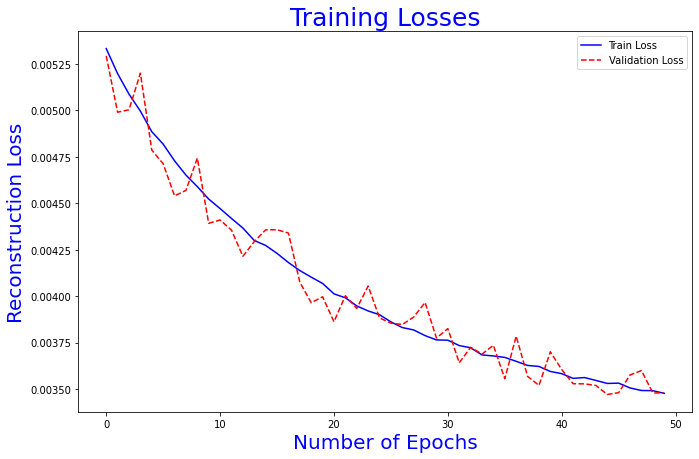

In [ ]:
# plotting loss
import matplotlib.pyplot as plt

plt.figure(figsize=(11,7))
plt.plot(train_loss, linestyle='-', color='blue', label="Train Loss")
plt.plot(val_loss, linestyle='--', color='red', label="Validation Loss")
plt.xlabel('Number of Epochs', size=20, color='blue')
plt.ylabel('Reconstruction Loss', size=20, color='blue')
plt.title("Training Losses", size=25, color='blue')
plt.legend()
plt.show()

# Save the model

In [ ]:
# torch.save(model.state_dict(), '/content/trained_model.pth')

# Loading the model

In [6]:
model = Embedder(28*28)
model.load_state_dict(torch.load('/content/autoencoder_MNIST.pth'))
model.to(device)

Embedder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

# Evaluation

In [ ]:
%%time

test_loss = []

test_l=0
for images, _ in test_loader:
  images = images.to(device)
  y_pred = model(images)
  loss = loss_fn(y_pred, images)

  #book-keeping
  test_l += loss.item()
test_l= test_l/len(test_loader)
test_loss.append(test_l)

print(f'Test Loss={sum(test_loss)/len(test_loss)}')

Test Loss=0.0036899007850913863
CPU times: user 1.52 s, sys: 7.02 ms, total: 1.53 s
Wall time: 1.53 s


## Reconstruction Samples

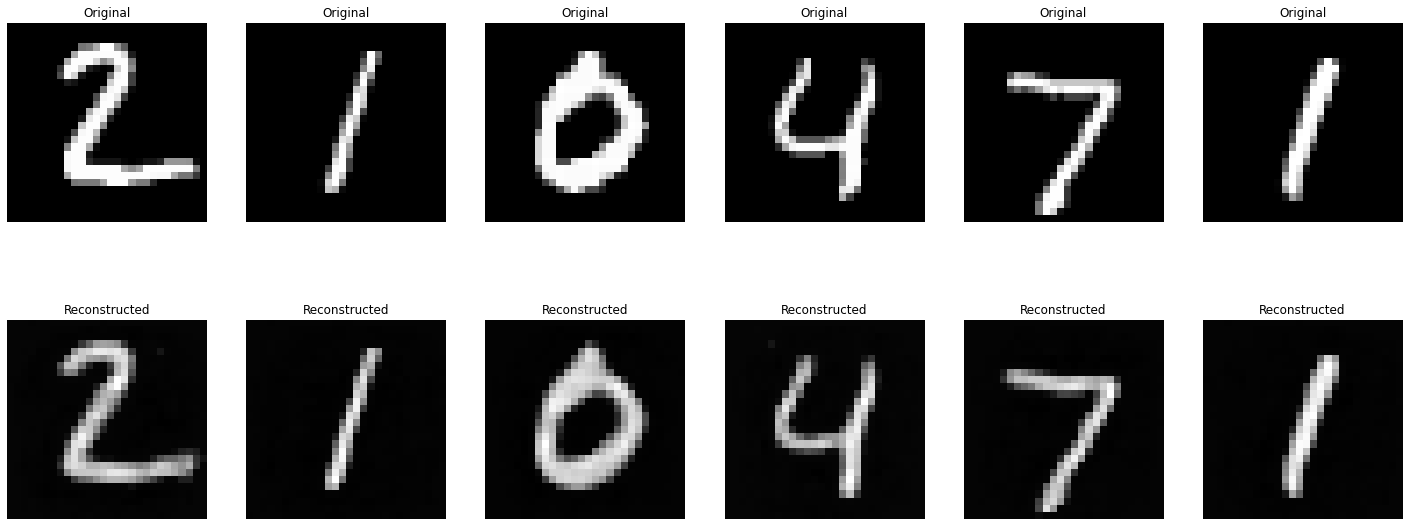

In [ ]:
n_samples = 6
sampler = torch.utils.data.sampler.SubsetRandomSampler(range(n_samples))
sample_loader = DataLoader( test_set, batch_size=1, sampler=sampler)

i=0
fig, ax = plt.subplots(nrows=2,ncols=6, figsize=(25,10))
for image, _ in sample_loader:
  reconstructed = model(image.to(device)).cpu().detach().numpy()

  ax[0][i].imshow(image.reshape(28,28), cmap='gray')
  ax[0][i].set_title('Original')
  ax[0][i].axis('off')
  ax[1][i].imshow(reconstructed.reshape(28,28), cmap='gray')
  ax[1][i].set_title('Reconstructed')
  ax[1][i].axis('off')
  i +=1

**Inference:**
- Since we are able to construct almost identical images of 28x28 dimension after embedding them into 8x8=64 dimensional latent space. **Thus we can use this network for embedding without much data loss.**

# Using for embedding
Visualizing 28x28 images being embedded into 8x8 latent space, which is given as the output by the encoders.  
>Note: Visualizng the embedding, which is actually linear layer input, by reshaping into 8x8.



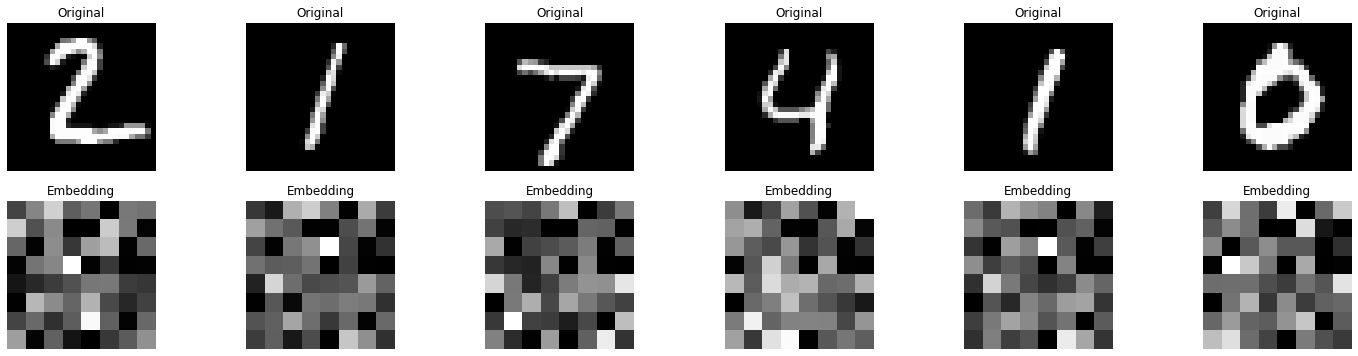

In [ ]:
n_samples = 6
sampler = torch.utils.data.sampler.SubsetRandomSampler(range(n_samples))  #take random 6 samples from test-set
sample_loader = DataLoader( test_set, batch_size=1, sampler=sampler)

i=0
fig, ax = plt.subplots(nrows=2,ncols=6, figsize=(25,6))
for image, _ in sample_loader:
  #get the embedding using only encoder part
  embedding = model.encoder(image.to(device)).cpu().detach().numpy()

  #plot
  ax[0][i].imshow(image.reshape(28,28), cmap='gray')
  ax[0][i].set_title('Original')
  ax[0][i].axis('off')
  ax[1][i].imshow(embedding.reshape(8,8), cmap='gray')
  ax[1][i].set_title('Embedding')
  ax[1][i].axis('off')
  i +=1

**Inference:**
- Since we are using Linear layers, they dont preserve spatial structure, thus visualizing embedding in image form as above is not useful.

# Each Layer output for a sample input
The network has two parts:
1. Encoder: 3 Linear layers with LeakyReLU as activation functions.
1. Decoder: 3 Linear layers with LeakyReLU as activation functions.

Below we visualize the input and the output from respective layers for the input. And finally the reconstructed image at last.

In [ ]:
#get the outputs


sample, _ = test_set[np.random.randint(0,len(test_set))]

images = [(0,'Input Image',sample.to(device).flatten())]

#encoder
for name, module in model.encoder.named_children():
  output = module(images[-1][2])
  images.append((name, type(module).__name__,output))

#decoder
for name, module in model.decoder.named_children():
  output = module(images[-1][2])
  images.append((name, type(module).__name__,output))

print(len(images))

13


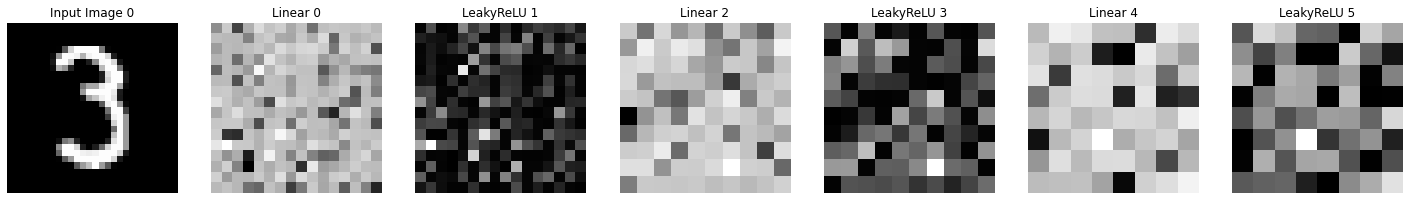

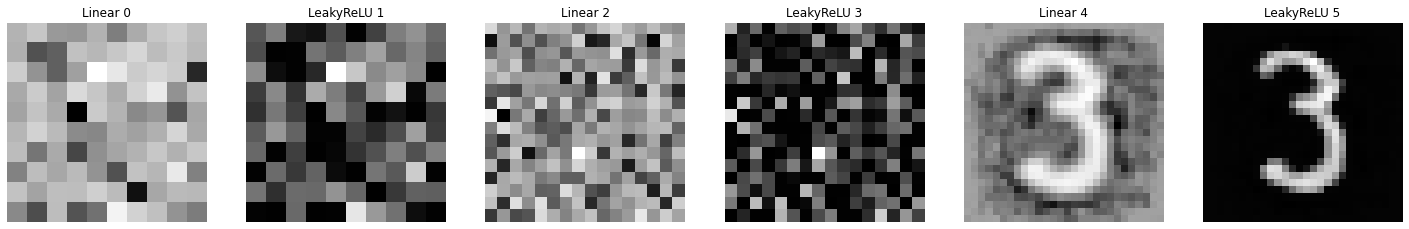

In [ ]:
#plot the outputs
#    in two rows: upper is encoder, lower is decoder


#encoder
col=0
fig, ax = plt.subplots(ncols=7, figsize=(25,20))
for number, typ, image in images[:7]:
  n = int(np.sqrt(len(image)))
  ax[col].imshow(image.cpu().detach().numpy().reshape(n,n), cmap='gray')
  ax[col].set_title(f'{typ} {number}')
  ax[col].axis('off')
  col +=1
plt.show()

#decoder
col=0
fig, ax = plt.subplots(ncols=6, figsize=(25,20))
for number, typ, image in images[7:]:
  n = int(np.sqrt(len(image)))
  ax[col].imshow(image.cpu().detach().numpy().reshape(n,n), cmap='gray')
  ax[col].set_title(f'{typ} {number}')
  ax[col].axis('off')
  col +=1
plt.show()

**Inference:**
- Because the mid-layers are Linear, thus there is no spatial structure like in images for them, thus reshaping them into image form is meaningless, as can be seen here.
- The LeakyReLU removes the noise from the output of final Linear Layer.

# Constructing from randomness
Since our decoder is taking a 8x8=64 dimensional vector of latent space and constructing a 28x28 image from it.  
Basically meaning decoder can take a vector from latent space and generate a corresponding image for that vector.  
  
  Thus below we take random vectors from latent space and construct images relating to them.

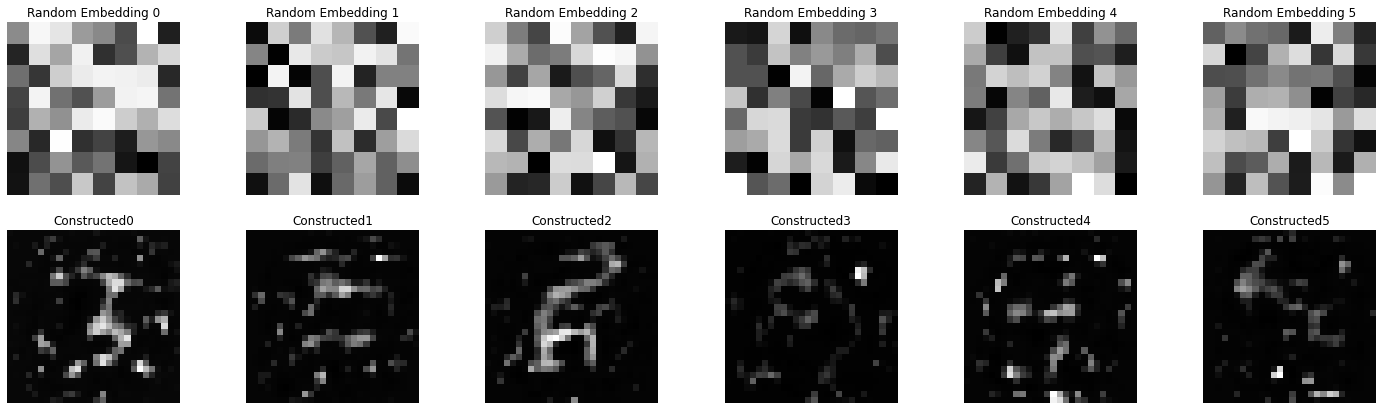

In [ ]:
n_samples
#generate random latent vectors
random_latent = 4*torch.rand(6, 8*8)-2


#plot
i=0
fig, ax = plt.subplots(nrows=2, ncols=n_samples, figsize=(25,7))
for random_l in random_latent:
  #reconstruct image from it
  output = model.decoder(random_l.to(device)).cpu().detach().numpy().reshape(28,28)

  #plot random latent vector
  ax[0][i].imshow(random_l.detach().numpy().reshape(8,8), cmap='gray')
  ax[0][i].set_title(f'Random Embedding {i}')
  ax[0][i].axis('off')

  #plot corresponding constructed image
  ax[1][i].imshow(output, cmap='gray')
  ax[1][i].set_title(f'Constructed{ i}')
  ax[1][i].axis('off')

  i +=1

**Inference:**
- Taking a random latent vector wont give proper construction.
- Maybe taking random latent vector from the latent vector distribution might give good results.

# Using for Denoising
1. The input image is being embedded into latent space by encoder.  
1. The decoder constructs image back from the latent space representation.

Thus, intuition is that if the input vector has noises, then during the process of embedding it into latent space, the noises might get lost in information Loss.  
And hence when we reconstruct back the image using decoder, the noises will be removed.

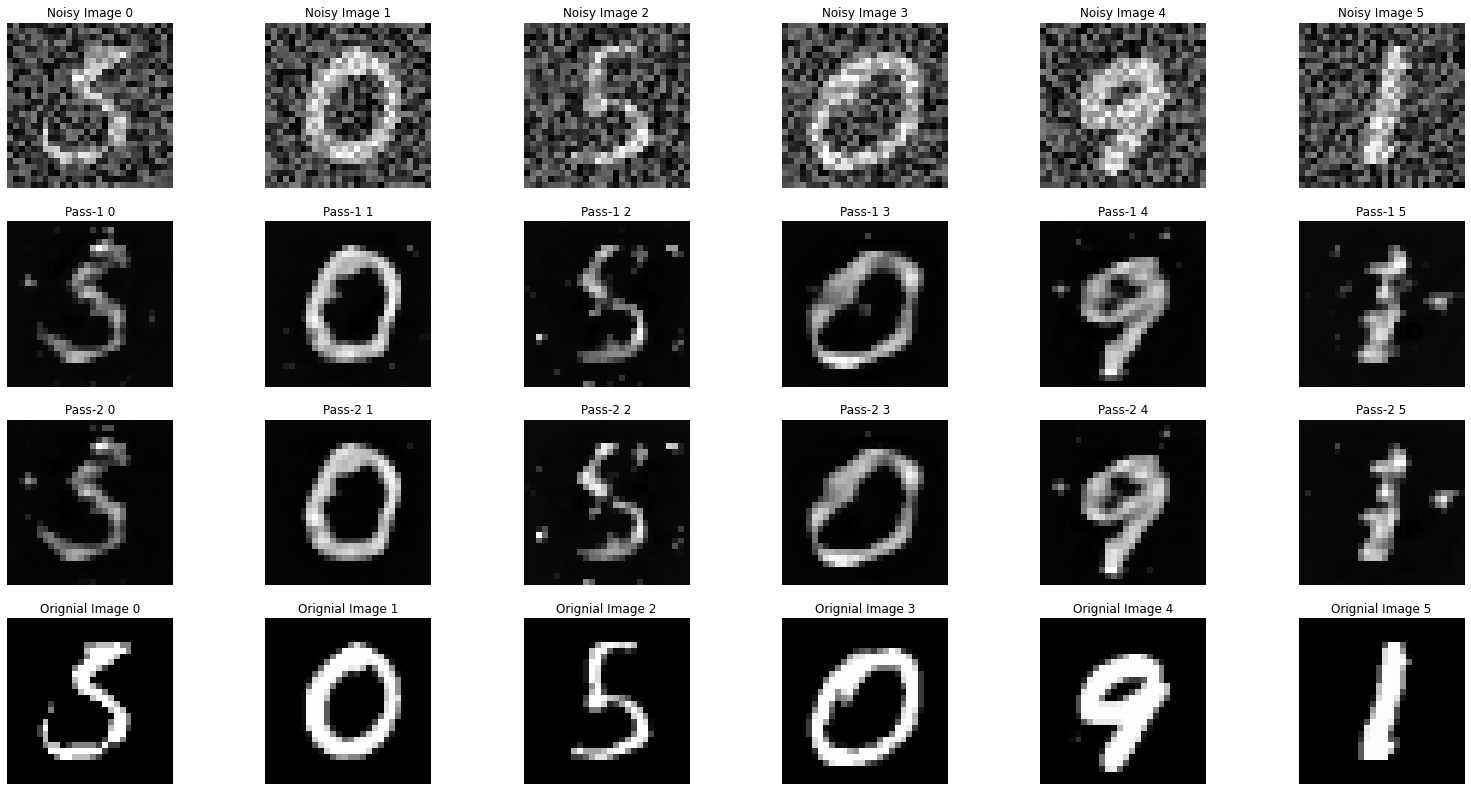

In [8]:
n_samples = 6
#generate random indexes
r_idxs = torch.randint(low=0, high=len(test_set), size=(n_samples,))
#get corresponding test images
samples = [test_set[i][0] for i in r_idxs]

#add noise to images
noises = torch.rand(n_samples, 784) -0.5

#add noise
corrupted = [samples[i]+noises[i] for i in range(n_samples)]

#pass through autoencoder
pass1 = [model(corrupted[i].to(device)).cpu() for i in range(n_samples)]

#pass again through autoencoder
pass2 = [model(pass1[i].to(device)).cpu() for i in range(n_samples)]


#plot
fig, ax = plt.subplots(nrows=4, ncols=n_samples, figsize=(27,14))
for i in range(n_samples):
  #plot noisy image
  ax[0][i].imshow(corrupted[i].reshape(28,28), cmap='gray')
  ax[0][i].set_title(f'Noisy Image {i}')
  ax[0][i].axis('off')

  #plot corresponding pass1 image
  ax[1][i].imshow(pass1[i].detach().numpy().reshape(28,28), cmap='gray')
  ax[1][i].set_title(f'Pass-1 {i}')
  ax[1][i].axis('off')

  #plot corresponding pass2 image
  ax[2][i].imshow(pass2[i].detach().numpy().reshape(28,28), cmap='gray')
  ax[2][i].set_title(f'Pass-2 {i}')
  ax[2][i].axis('off')

  #plotting the original images
  ax[3][i].imshow(samples[i].reshape(28,28), cmap='gray')
  ax[3][i].set_title(f'Orignial Image {i}')
  ax[3][i].axis('off')

**Inference:**
- Its clearly visible that the model did indeed denoise the image to great extent.
- Second pass did clean a little but not that much, thus it might not be worth it.

# Receptive field
Will it still work properly for an image consisting of multiple handwritten digits? In other words how is its receptive field?  
Below we will compose 4 test images, pool them to get 28x28 dimension and feed to autoencoder.

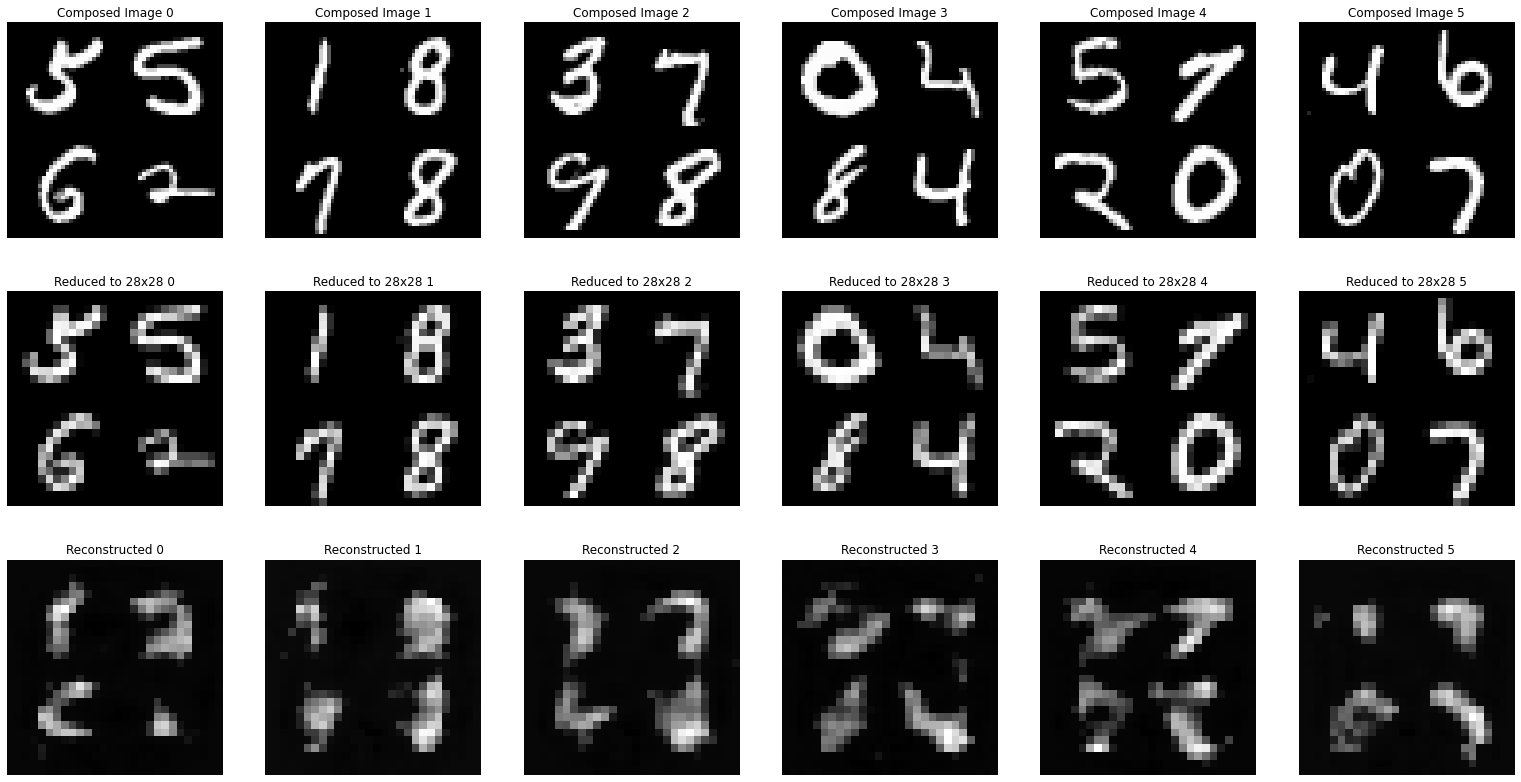

In [27]:
n_samples = 6

#generate random indexes
r_idxs = torch.randint(low=0, high=len(test_set), size=(n_samples,))
#get images - top left
top_left = [test_set[i][0].reshape(28,28) for i in r_idxs]
#generate random indexes
r_idxs = torch.randint(low=0, high=len(test_set), size=(n_samples,))
#get images - top right
top_right = [test_set[i][0].reshape(28,28) for i in r_idxs]
#generate random indexes
r_idxs = torch.randint(low=0, high=len(test_set), size=(n_samples,))
#get images - bottom left
bottom_left = [test_set[i][0].reshape(28,28) for i in r_idxs]
#generate random indexes
r_idxs = torch.randint(low=0, high=len(test_set), size=(n_samples,))
#get images - bottom right
bottom_right = [test_set[i][0].reshape(28,28) for i in r_idxs]


composed_top = [torch.cat([top_left[i], top_right[i]], dim=1) for i in range(n_samples)]
composed_bottom = [torch.cat([bottom_left[i], bottom_right[i]], dim=1) for i in range(n_samples)]
composed = [torch.cat([composed_top[i], composed_bottom[i]], dim=0) for i in range(n_samples)]


#reduce the dimension
maxpool = nn.AvgPool2d(kernel_size=2, stride=2)
reduced = [maxpool(composed[i].unsqueeze(0)) for i in range(n_samples)]

#pass through autoencoder
reconstructed = [model(reduced[i].flatten().to(device)).cpu() for i in range(n_samples)]


#plot
fig, ax = plt.subplots(nrows=3, ncols=n_samples, figsize=(27,14))
for i in range(n_samples):
  #plot original composite image
  ax[0][i].imshow(composed[i].reshape(28*2,28*2), cmap='gray')
  ax[0][i].set_title(f'Composed Image {i}')
  ax[0][i].axis('off')

  # #plot reduced dimension image
  ax[1][i].imshow(reduced[i].detach().numpy().reshape(28,28), cmap='gray')
  ax[1][i].set_title(f'Reduced to 28x28 {i}')
  ax[1][i].axis('off')

  # #plot reconstructed image
  ax[2][i].imshow(reconstructed[i].detach().numpy().reshape(28,28), cmap='gray')
  ax[2][i].set_title(f'Reconstructed {i}')
  ax[2][i].axis('off')

**Inference:**
- The autoencoder is catching the shape of the digits vaguely.
- But overall the autoencoder didnt perform well for composite images.
- Possibly if the autoencoder was built using convolutional layers, it would have learned the features of the images, and thus could have worked for composite images too.